总结：  
思路是双均线看涨跌趋势，选择一个反转信号作多空判断，本策略选择的是MACD反转信号。具体做法是寻找DEA线与close线趋势发生背离的反转信号，期间尝试了向这个策略中添加其他策略如通道策略等，但是多次尝试发现效果不佳，故只保留了双均线+MACD反转。止盈止损策略是固定点数止盈止损。  

BTC回测过程中发现的主要问题是：策略常常在六月下旬到七月上旬以及八月份发生非常严重的回撤，因此参数优化也围绕这两个时间段展开，先后优化了双均线的长短周期、止盈止损的截至点数和止盈止损盈亏比，优化后的参数与未优化前相比，半年内的夏普率有好转。  

除60Min外，还分别尝试了其他周期（30min、15min），从回测绩效来看，周期越短夏普率越差，该策略的跨周期通用性较差。在EOS的五个月交易中绩效较差。

In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np
from datetime import timedelta


########################################################################
# 策略继承CtaTemplate
class MacdReversalStrategy(CtaTemplate):
    """Macd反转策略Demo"""
    className = 'MacdReversalStrategy'
    author = 'Boyang Lyu'
    
    # 策略参数
    lot = 1         # 设置手数
    holdHour = 20    # 最长持有时间
    fastPeriod = 21
    slowPeriod = 53
    stopRatio = 0.03
    takeLossRatio = 7
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    maTrend = {}
    
    # 参数列表
    paramList = ['lot',
                 'holdHour',
                 'fastPeriod',
                 'slowPeriod',
                 'stopRatio',
                 'takeLossRatio']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把ReversalStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    #----------------------------------------------------------------------
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol] * (1 - self.stopRatio)
        longProfit = self.transactionPrice[symbol] * (1 + self.takeLossRatio * self.stopRatio)
        shortStop = self.transactionPrice[symbol] * (1 + self.stopRatio)
        shortProfit = self.transactionPrice[symbol] * (1 - self.takeLossRatio * self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                #print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                #print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                #print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                #print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        # 计算均线并判断趋势-------------------------------------------------
        fastEMa = ta.EMA(am60.close, self.fastPeriod)
        slowEMa = ta.EMA(am60.close, self.slowPeriod)
        
        if (fastEMa[-1] > slowEMa[-1]) and (fastEMa[-2] < slowEMa[-2]):
            self.maTrend[symbol] = 1
        elif (fastEMa[-1] < slowEMa[-1]) and (fastEMa[-2] > slowEMa[-2]):
            self.maTrend[symbol] = -1
        else:
            self.maTrend[symbol] = self.maTrend[symbol]

        # 计算策略需要的信号-------------------------------------------------
        diff,dea,hist = ta.MACD(am60.close)
        
        #当 DEA 线与 K 线趋势发生背离时为反转信号;价格创新高，而指标没有创新高，顶背离，看跌;价格创新低，而指标没有创新低，底背离，看涨
        deaDvgUp = (am60.close[-1] < am60.close[-2]) and (dea[-1] >= dea[-2])
        deaDvgDn = (am60.close[-1] > am60.close[-2]) and (dea[-1] <= dea[-2])
        
        # 构建进出场逻辑-------------------------------------------------
        if (self.maTrend[symbol] == 1) and deaDvgUp and (self.posDict[symbol+'_LONG'] == 0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        elif (self.maTrend[symbol] == -1) and deaDvgDn and (self.posDict[symbol+'_SHORT']== 0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180701 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181201 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MacdReversalStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-22 20:13:41.162289	开始回测
2018-12-22 20:13:41.162289	策略初始化
2018-12-22 20:13:41.748975	数据载入完成, 时间段:[20180623 04:00,20180701 12:00);数据量:11295
2018-12-22 20:13:41.748975	初始化预加载数据成功, 数据长度:11295
2018-12-22 20:13:41.748975	策略初始化完成
2018-12-22 20:13:41.748975	策略启动完成
2018-12-22 20:13:41.749458	回测时间范围:[20180701 12:00,20181201 12:00)
2018-12-22 20:13:41.749458	当前回放的时间段:[20180701 12:00,20181201 12:00)
2018-12-22 20:13:51.056084	数据载入完成, 时间段:[20180701 12:00,20181201 12:00);数据量:219233
2018-12-22 20:13:51.217801	数据载入完成, 时间段:[20180630 20:51,20180703 12:01);数据量:3790
2018-12-22 20:13:53.564930	数据载入完成, 时间段:[20180524 15:00,20180630 20:50);数据量:52925
2018-12-22 20:13:53.571410	WARNING: 该时间段:[20180703 12:01,20180703 13:00) 数据量为0!
2018-12-22 20:14:08.999106	回放结束ress: 100%    


2018-12-22 20:14:33.513725	计算按日统计结果
2018-12-22 20:14:33.561634	------------------------------
2018-12-22 20:14:33.562132	首个交易日：	2018-07-01 00:00:00
2018-12-22 20:14:33.562132	最后交易日：	2018-12-01 00:00:00
2018-12-22 20:14:33.562132	总交易日：	154
2018-12-22 20:14:33.562132	盈利交易日	85
2018-12-22 20:14:33.562132	亏损交易日：	62
2018-12-22 20:14:33.562132	起始资金：	1000000
2018-12-22 20:14:33.562132	结束资金：	1,004,794.0
2018-12-22 20:14:33.562632	总收益率：	0.48%
2018-12-22 20:14:33.562632	年化收益：	0.75%
2018-12-22 20:14:33.563131	总盈亏：	4,794.0
2018-12-22 20:14:33.563632	最大回撤: 	-970.27
2018-12-22 20:14:33.563632	百分比最大回撤: -0.1%
2018-12-22 20:14:33.563632	总手续费：	313.1
2018-12-22 20:14:33.563632	总滑点：	0.19
2018-12-22 20:14:33.563632	总成交金额：	626,205.06
2018-12-22 20:14:33.563632	总成交笔数：	97
2018-12-22 20:14:33.563632	日均盈亏：	31.13
2018-12-22 20:14:33.563632	日均手续费：	2.03
2018-12-22 20:14:33.563632	日均滑点：	0.0
2018-12-22 20:14:33.564129	日均成交金额：	4,066.27
2018-12-22 20:14:33.564129	日均成交笔数：	0.63
2018-12-22 20:14:33.564129	日均收益率：	0.0%
2018

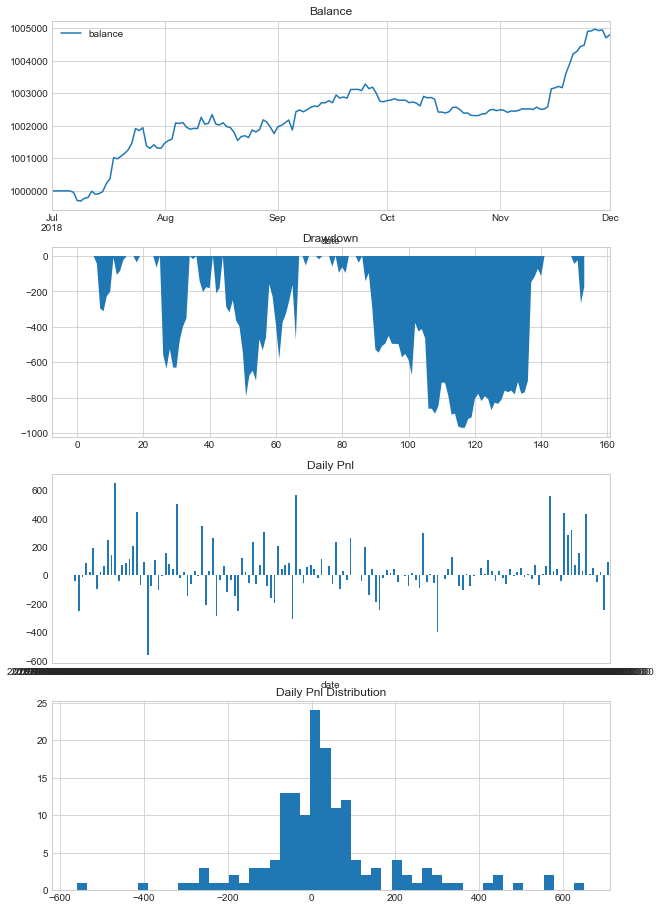

In [3]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-22 20:14:48.201345	计算回测结果
2018-12-22 20:14:48.206318	------------------------------
2018-12-22 20:14:48.206318	第一笔交易：	2018-07-08 03:00:00
2018-12-22 20:14:48.206817	最后一笔交易：	2018-12-01 11:58:00
2018-12-22 20:14:48.206817	总交易次数：	49
2018-12-22 20:14:48.206817	总盈亏：	4,791.99
2018-12-22 20:14:48.206817	最大回撤: 	-760.04
2018-12-22 20:14:48.206817	平均每笔盈利：	97.8
2018-12-22 20:14:48.206817	平均每笔滑点：	0.0
2018-12-22 20:14:48.206817	平均每笔佣金：	6.43
2018-12-22 20:14:48.206817	胜率		42.86%
2018-12-22 20:14:48.206817	盈利交易平均值	375.1
2018-12-22 20:14:48.207315	亏损交易平均值	-110.19
2018-12-22 20:14:48.207315	盈亏比：	3.4


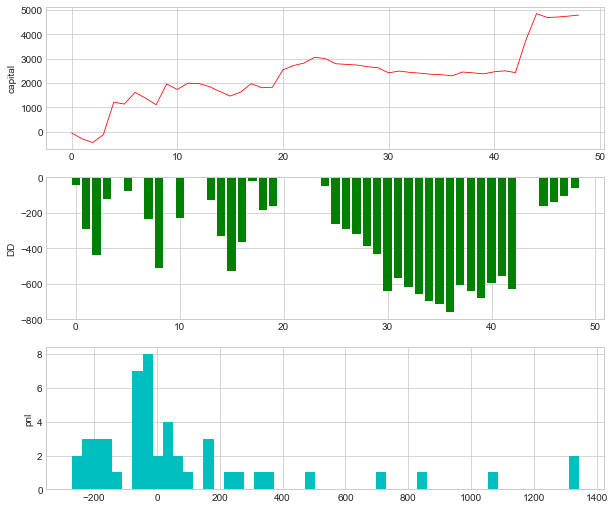

In [4]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [164]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')       # 设置优化排序的目标是夏普

setting.addParameter('takeLossRatio', 6, 10, 1)
#setting.addParameter('slowPeriod', 53, 55, 1)

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(ReversalStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(Strategy, setting)
# print('耗时：%s' %(time.time()-start))

2018-12-16 19:49:21.121708	------------------------------
2018-12-16 19:49:21.121708	setting: {'takeLossRatio': 6, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function ReversalStrategy.on60MinBar at 0x000001E91A4EC378>, <__main__.ReversalStrategy object at 0x000001E91A122FD0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ReversalStrategy.onBar at 0x000001E91A4EC950>, <__main__.ReversalStrategy object at 0x000001E91A122FD0>)
2018-12-16 19:49:21.143666	开始回测
2018-12-16 19:49:21.144166	策略初始化
2018-12-16 19:49:21.147660	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-16 19:49:21.594326	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 19:49:21.598818	载入完成，数据量：12000
2018-12-16 19:49:21.599817	策略初始化完成
2018-12-16 19:49:21.599817	策略启动完成
2018-12-16 19:49:21.600316	开始回放回测数据,回测范围:[20180615 12:00,20180901 12:00)
2018-12-16 19:49:21.609312	载入历史数据。数据范围:[2

2018-12-16 19:50:07.386984	------------------------------
2018-12-16 19:50:07.386984	setting: {'takeLossRatio': 9, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function ReversalStrategy.on60MinBar at 0x000001E91D922C80>, <__main__.ReversalStrategy object at 0x000001E91C625F98>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ReversalStrategy.onBar at 0x000001E931C51F28>, <__main__.ReversalStrategy object at 0x000001E91C625F98>)
2018-12-16 19:50:07.407959	开始回测
2018-12-16 19:50:07.408442	策略初始化
2018-12-16 19:50:07.409440	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-16 19:50:08.063611	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 19:50:08.068592	载入完成，数据量：12000
2018-12-16 19:50:08.069091	策略初始化完成
2018-12-16 19:50:08.069590	策略启动完成
2018-12-16 19:50:08.069590	开始回放回测数据,回测范围:[20180615 12:00,20180901 12:00)
2018-12-16 19:50:08.079086	载入历史数据。数据范围:[2

In [ ]:
1.27